# 40x vs 20x Analysis

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from skimage import io
from skimage.util.shape import view_as_blocks
from scipy.spatial import cKDTree as KDTree
from sklearn.metrics import auc
import seaborn as sns
from tqdm import tqdm

In [2]:
# Levenshtein distance (https://en.wikibooks.org/wiki/Algorithm_Implementation/Strings/Levenshtein_distance#Python)
def levenshtein(s1, s2):
    """ Function to compute Levenshtein distance between two strings.
        Returns the number of mismatches between the two strings.
        
        s1 : first string
        s2 : second string
    """
    if len(s1) < len(s2):
        return levenshtein(s2, s1)

    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1 # j+1 instead of j since previous_row and current_row are one character longer
            deletions = current_row[j] + 1       # than s2
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

In [3]:
def wrapCoords(a, tMatrix, offset): 
    """ Apply affine tranformation to a set of pair of coordinates.
        Returns transformed set of pair of coordinates
    
        a : set of pairs of coords
        tMatrix : affine transformation matrix
        offset : transformation offset
    """
    return np.dot(tMatrix, a) + offset

def PointCloudReg(y0,x0,DistScale):
    """ Point cloud registration to map points x0 onto points y0 by iterative closest point:
        repeatedly finding the best y0 for each x0, and doing linear regression to find the transformatin matrix M.
        
        that best maps x0 to y0.
        y0: target point cloud§
        x0: source point cloud
        DistScale: any x0 whose nearest neighbor is further than this won't count
    """
    MaxIter = 10000
    Interactive = 0
    
    (nP,nD)=source.shape
    x=x0
    
    M0 = np.eye(nD)
    M = M0;
    k0 = KDTree(y0)
    
    # Find well isolated points
    d,idx = k0.query(y0,2)
    y = y0[d[:,1]>DistScale*2,:]
    
    k = KDTree(y)
    idx = np.zeros((nP,1))
    for i in range(MaxIter):
        LastNeighbor = idx
        xM = np.dot(x,M)
        d,idx = k.query(xM,distance_upper_bound=DistScale)
        idx = idx[~(d==np.inf)]
        nMatches = len(idx);
        M = np.linalg.lstsq(x[d!=np.inf],y[idx,:])[0]
        
        Error = np.sqrt(np.mean(np.power(d[d!=np.inf],2)));
        
        if np.array_equal(LastNeighbor, idx):
            break
        
    return {'M':M, 'Error':Error, 'nMatches':nMatches}

def runROC(exp_df,unexp_df):
    ppv = []
    tnr = []
    tpr = []
    fpr = []
    n_bins = 100
    fp_minQ = unexp_df.Q.min()
    fp_maxQ = unexp_df.Q.max()
    tp_minQ = exp_df.Q.min()
    tp_maxQ = exp_df.Q.max()
    Q_min = np.amin([fp_minQ,tp_minQ])
    Q_max = np.amax([fp_maxQ,tp_maxQ])
    step = (Q_max-Q_min)/n_bins
    Q=Q_min
    for n in range(n_bins):
        tp = len(exp_df[exp_df.Q>=Q])
        fp = len(unexp_df[unexp_df.Q>=Q])
        tn = len(unexp_df[unexp_df.Q<Q])
        fn = len(exp_df[exp_df.Q<Q])
        ppv.append(tp/(tp+fp))
        tnr.append(tn/(tn+fp))
        tpr.append(tp/(tp+fn))
        fpr.append(fp/(fp+tn))
        Q = Q + step
    return fpr, tpr, auc(fpr, tpr)

# Find best quality threshold that miximize expected vs unexpected separation
def find_d1_param(barcodes_df, tagList_df):
    r = np.linspace(2,5,20) # 20 linearly spaced numbers
    auc_list=[]
    for v in tqdm(r):
        def T_quality(x):
            return np.clip(1-np.log(1+x)/v,0,1)
        barcodes_df["Q"]=barcodes_df.seq_quality_min*barcodes_df.max_dist.apply(T_quality)

        exp_df = barcodes_df[barcodes_df.letters.isin(tagList_df.Seq)]
        unexp_df = barcodes_df[~barcodes_df.letters.isin(tagList_df.Seq)]
        unexp_tagList = unexp_df.letters.unique()
        auc_list.append(runROC(exp_df,unexp_df)[-1])

    return r[np.argmax(auc_list)]

## Unexpected vs Expected Comparison

ROC curvers and mismatch histograms are computed using as ground truth the codes in the taglist.

100%|██████████| 20/20 [00:54<00:00,  2.65s/it]


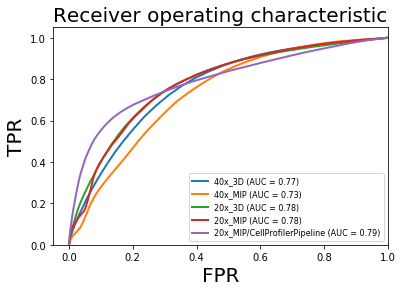

In [4]:
tagList_df = pd.read_csv("../data/tagList_99-gene.csv", sep = ",", usecols = [0], header = None, names = ["Seq"])

def ROC(exp_df,unexp_df):
    ppv = []
    tnr = []
    tpr = []
    fpr = []
    n_bins = 100
    fp_minQ = unexp_df.seq_quality_min.min()
    fp_maxQ = unexp_df.seq_quality_min.max()
    tp_minQ = exp_df.seq_quality_min.min()
    tp_maxQ = exp_df.seq_quality_min.max()
    Q_min = np.amin([fp_minQ,tp_minQ])
    Q_max = np.amax([fp_maxQ,tp_maxQ])
    step = (Q_max-Q_min)/n_bins
    Q=Q_min
    for n in range(n_bins):
        tp = len(exp_df[exp_df.seq_quality_min>=Q])
        fp = len(unexp_df[unexp_df.seq_quality_min>=Q])
        tn = len(unexp_df[unexp_df.seq_quality_min<Q])
        fn = len(exp_df[exp_df.seq_quality_min<Q])
        ppv.append(tp/(tp+fp))
        tnr.append(tn/(tn+fp))
        tpr.append(tp/(tp+fn))
        fpr.append(fp/(fp+tn))
        Q = Q + step
    return fpr, tpr, auc(fpr, tpr)

# Plot ROC
for i,dataset in enumerate(['40x_3D','40x_MIP','20x_3D','20x_MIP','20x_MIP/CellProfilerPipeline']):
    barcodes_df = pd.read_csv("../data/results/170315_161220_4_1/"+dataset+"/barcodes.csv", sep = ",")

    if dataset != '20x_MIP/CellProfilerPipeline':
        d1 = find_d1_param(barcodes_df,tagList_df)
        def T_quality(x):
            return np.clip(1-np.log(1+x)/d1,0,1)
        barcodes_df.seq_quality_min=barcodes_df.seq_quality_min*barcodes_df.max_dist.apply(T_quality)
    else:
        DO_th=0.01
        barcodes_df = barcodes_df.dropna()
        barcodes_df=barcodes_df[barcodes_df.DO_intensity>=DO_th]
        barcodes_df["Q"] = barcodes_df.apply(lambda row: np.min([row['seq_quality_1'], row['seq_quality_2'],row['seq_quality_3'],row['seq_quality_4'],row['seq_quality_5']]), axis=1)
        barcodes_df = barcodes_df.drop(['seq_quality_1','seq_quality_2', 'seq_quality_3', 'seq_quality_4', 'seq_quality_5'],axis=1)
        barcodes_df.columns = ['letters','global_X_pos','global_Y_pos','general_stain_min','seq_quality_min']
        
    # Exclude homopolymers
    barcodes_df = barcodes_df[(barcodes_df.letters!="AAAAA") & (barcodes_df.letters!="CCCCC") & (barcodes_df.letters!="TTTTT") & (barcodes_df.letters!="GGGGG")]

    exp_df = barcodes_df[barcodes_df.letters.isin(tagList_df.Seq)]
    unexp_df = barcodes_df[~barcodes_df.letters.isin(tagList_df.Seq)]

    fpr, tpr, AUC = ROC(exp_df,unexp_df)
    
    # plot
    lw = 2
    plt.plot(fpr, tpr,  lw=lw, label=str(dataset) + ' (AUC = %0.2f)' % AUC)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR',fontsize=20)
    plt.ylabel('TPR', fontsize=20)
    plt.title('Receiver operating characteristic',fontsize=20)
    plt.legend(loc="lower right", fontsize=8)

100%|██████████| 293183/293183 [11:31<00:00, 423.70it/s]
/home/gapartel/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/gapartel/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
100%|██████████| 193269/193269 [07:47<00:00, 413.01it/s]


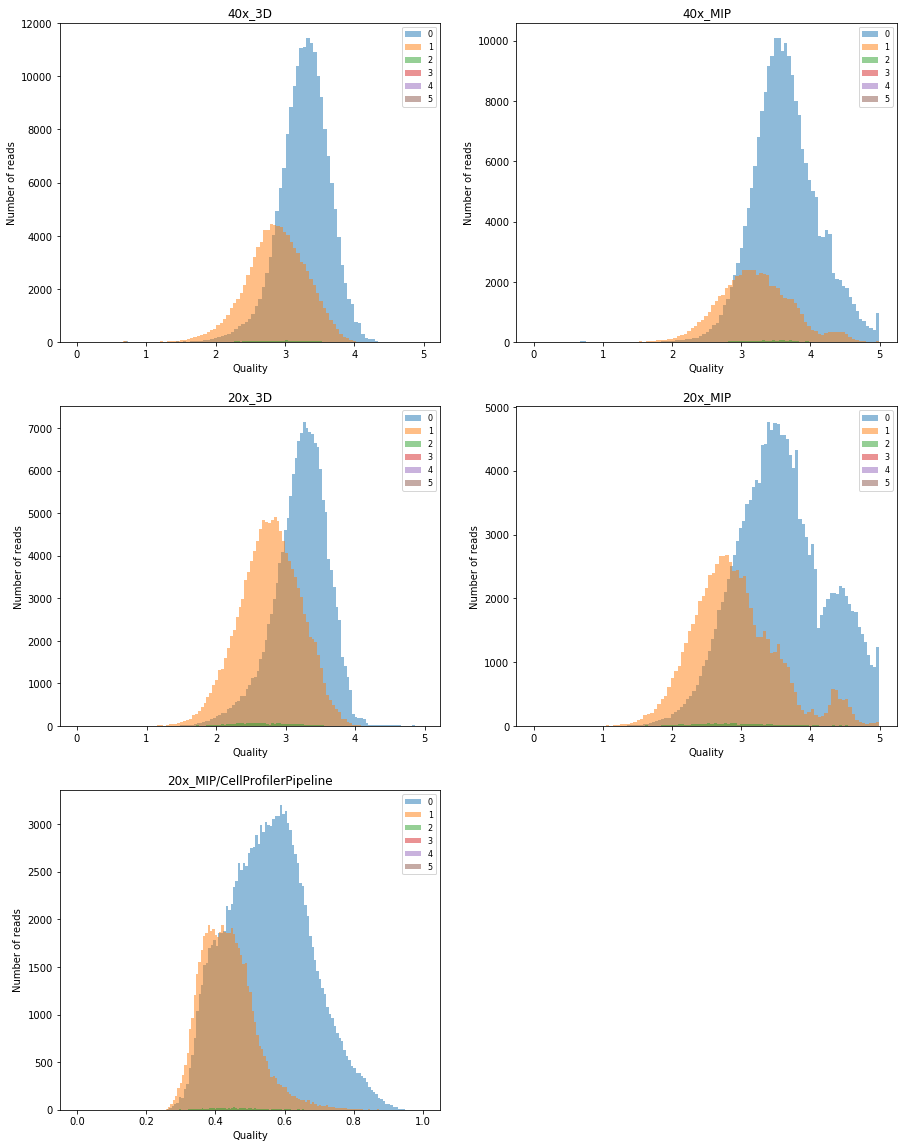

In [5]:
def evaluateLevenshteinDist(sequence,tagList):
    return np.min([levenshtein(sequence,x) for x in tagList])
    
# Plot Histograms
plt.figure(figsize=(15,20))
for i,dataset in enumerate(['40x_3D','40x_MIP','20x_3D','20x_MIP','20x_MIP/CellProfilerPipeline']):
    barcodes_df = pd.read_csv("../data/results/170315_161220_4_1/"+dataset+"/barcodes.csv", sep = ",")

    if dataset != '20x_MIP/CellProfilerPipeline':
        d1 = find_d1_param(barcodes_df,tagList_df)
        def T_quality(x):
            return np.clip(1-np.log(1+x)/d1,0,1)
        barcodes_df.seq_quality_min=barcodes_df.seq_quality_min*barcodes_df.max_dist.apply(T_quality)
    else:
        DO_th=0.01
        barcodes_df = barcodes_df.dropna()
        barcodes_df=barcodes_df[barcodes_df.DO_intensity>=DO_th]
        barcodes_df["Q"] = barcodes_df.apply(lambda row: np.min([row['seq_quality_1'], row['seq_quality_2'],row['seq_quality_3'],row['seq_quality_4'],row['seq_quality_5']]), axis=1)
        barcodes_df = barcodes_df.drop(['seq_quality_1','seq_quality_2', 'seq_quality_3', 'seq_quality_4', 'seq_quality_5'],axis=1)
        barcodes_df.columns = ['letters','global_X_pos','global_Y_pos','general_stain_min','seq_quality_min']
    
    # Exclude homopolymers
    barcodes_df = barcodes_df[(barcodes_df.letters!="AAAAA") & (barcodes_df.letters!="CCCCC") & (barcodes_df.letters!="TTTTT") & (barcodes_df.letters!="GGGGG")]


    def evaluateLevenshteinDist(sequence):
        return np.min([levenshtein(sequence,x) for x in tagList_df.Seq])

    tqdm.pandas()
    barcodes_df['min_n_mismatch'] = barcodes_df.letters.progress_apply(evaluateLevenshteinDist)
    
    plt.subplot(3,2,i+1)
    for j in range(len(barcodes_df.letters[0])+1):
        plt.hist(np.array(barcodes_df[barcodes_df.min_n_mismatch==j].seq_quality_min),bins=100,alpha=0.5,label=str(j))
    plt.legend(fontsize=8)
    plt.title(dataset)
    plt.xlabel("Quality")
    plt.ylabel("Number of reads")

## 40x 3D Ground Truth

### Align datasets
Align the coordinates of decoded reads to the 40x 3D results referenced as ground truth.

In [6]:
# Load reference image
img = np.amax(io.imread('../data/ref_img.tif'),axis=0)
dataset_list = ['20x_3D','20x_MIP',"20x_MIP/CellProfilerPipeline"]

/home/gapartel/miniconda3/lib/python3.7/site-packages/skimage/external/tifffile/tifffile.py:1834: UserWarning: ome-xml: index out of range
  warnings.warn("ome-xml: index out of range")
/home/gapartel/miniconda3/lib/python3.7/site-packages/skimage/external/tifffile/tifffile.py:2573: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  tile = decompress(tile)
/home/gapartel/miniconda3/lib/python3.7/site-packages/skimage/external/tifffile/tifffile.py:2579: UserWarning: invalid tile data
  warnings.warn("invalid tile data")


In [7]:
for dataset in tqdm(dataset_list):
    print(dataset)
    barcodes_df = pd.read_csv("../data/results/170315_161220_4_1/"+dataset+"/barcodes.csv", sep = ",")
    target_df = pd.read_csv("../data/results/170315_161220_4_1/40x_3D/barcodes.csv", sep = ",")
    tagList_df = pd.read_csv("../data/tagList_99-gene.csv", sep = ",", usecols = [0], header = None, names = ["Seq"])
    
    if dataset=="20x_MIP/CellProfilerPipeline":
        DO_th=0.01
        barcodes_df = barcodes_df.dropna()
        barcodes_df=barcodes_df[barcodes_df.DO_intensity>=DO_th]
        barcodes_df["Q"] = barcodes_df.apply(lambda row: np.min([row['seq_quality_1'], row['seq_quality_2'],row['seq_quality_3'],row['seq_quality_4'],row['seq_quality_5']]), axis=1)
        barcodes_df = barcodes_df.drop(['seq_quality_1','seq_quality_2', 'seq_quality_3', 'seq_quality_4', 'seq_quality_5'],axis=1)
        barcodes_df.columns = ['letters','global_X_pos','global_Y_pos','general_stain_min','seq_quality_min']
    else:
        d1 = find_d1_param(barcodes_df,tagList_df)
    
        def T_quality(x):
            return np.clip(1-np.log(1+x)/d1,0,1)

        barcodes_df.seq_quality_min=barcodes_df.seq_quality_min*barcodes_df.max_dist.apply(T_quality)

            
    # Remove Homopolymer
    target_df = target_df[(target_df.letters!="AAAAA") & (target_df.letters!="CCCCC") & (target_df.letters!="TTTTT") & (target_df.letters!="GGGGG")]
    barcodes_df = barcodes_df[(barcodes_df.letters!="AAAAA") & (barcodes_df.letters!="CCCCC") & (barcodes_df.letters!="TTTTT") & (barcodes_df.letters!="GGGGG")]

    if dataset!='40x_MIP':
        # Crop exhiding part
        barcodes_df = barcodes_df[(barcodes_df.global_Y_pos < 6000)]
        tM = [1.997056969156388, -0.0049531684766723014, 0.005268331486827726, 1.9975368521360117, 230.32294100963057, 268.4132109854172]
        tMatrix = np.array([[tM[3], tM[1]], [tM[2], tM[0]]])
        offset = np.array([[tM[5]], [tM[4]]])
        
        # Apply Affine transformation from SIFT Feature based landmark registration of general stain images
        tCoords =  np.squeeze(np.array([wrapCoords(np.array([[barcodes_df.loc[x,'global_Y_pos']],[barcodes_df.loc[x,'global_X_pos']]]), tMatrix, offset) for x in barcodes_df.index]))
        barcodes_df["tX"] = tCoords[:,1]
        barcodes_df["tY"] = tCoords[:,0]
    else:
        barcodes_df["tX"] = barcodes_df["global_X_pos"]
        barcodes_df["tY"] = barcodes_df["global_Y_pos"]
    Q_th=0
    source = np.squeeze(np.array([list(barcodes_df.loc[barcodes_df.seq_quality_min>Q_th,'tX']),list(barcodes_df.loc[barcodes_df.seq_quality_min>Q_th,'tY']),list(np.ones(len(barcodes_df[barcodes_df.seq_quality_min>Q_th])))])).T
    target = np.squeeze(np.array([[target_df.loc[:,'global_X_pos']],[target_df.loc[:,'global_Y_pos']],[np.ones(len(target_df))]])).T
    
    patch_size=(1120,1376)
    coord_max =np.array([12008,9960,1])
    coord_min =np.array([1000,1000,1])
    source = source[(source[:,0] <= coord_max[0]) & (source[:,1] <= coord_max[1]) & ((source[:,0] >= coord_min[0]) & (source[:,1] >= coord_min[1]))]
    target = target[(target[:,0] <= coord_max[0]) & (target[:,1] <= coord_max[1]) & ((target[:,0] >= coord_min[0]) & (target[:,1] >= coord_min[1]))]
    
    img_patches = view_as_blocks(img[coord_min[1]:coord_max[1],coord_min[0]:coord_max[0]], block_shape=patch_size)
    
    # Perform second alignment, locally affine point cloud registration.
    for i in range(img_patches.shape[1]):
        for j in range(img_patches.shape[0]):
            barcodes_df_tmp = barcodes_df[(barcodes_df.tX>=coord_min[0]+i*patch_size[1]) & (barcodes_df.tX<=coord_min[0]+i*patch_size[1]+patch_size[1]) & (barcodes_df.tY>=coord_min[1]+j*patch_size[0]) & (barcodes_df.tY<=coord_min[1]+j*patch_size[0]+patch_size[0])]
            source_tmp = source[(source[:,0]>=coord_min[0]+i*patch_size[1]) & (source[:,0]<=coord_min[0]+i*patch_size[1]+patch_size[1]) & (source[:,1]>=coord_min[1]+j*patch_size[0]) & (source[:,1]<=coord_min[1]+j*patch_size[0]+patch_size[0])]
            target_tmp = target[(target[:,0]>=coord_min[0]+i*patch_size[1]) & (target[:,0]<=coord_min[0]+i*patch_size[1]+patch_size[1]) & (target[:,1]>=coord_min[1]+j*patch_size[0]) & (target[:,1]<=coord_min[1]+j*patch_size[0]+patch_size[0])]
            M=PointCloudReg(target_tmp,source_tmp,5)['M']
            
            tM = [M[0,0], M[0,1], M[1,0], M[1,1], M[2,0], M[2,1]]
            tMatrix = np.array([[tM[3], tM[1]], [tM[2], tM[0]]])
            offset = np.array([[tM[5]], [tM[4]]])
    
            tCoords =  np.squeeze(np.array([wrapCoords(np.array([[barcodes_df_tmp.loc[x,'tY']],[barcodes_df_tmp.loc[x,'tX']]]), tMatrix, offset) for x in barcodes_df_tmp.index]))
            barcodes_df.loc[barcodes_df_tmp.index,"tX2"] = tCoords[:,1]
            barcodes_df.loc[barcodes_df_tmp.index,"tY2"] = tCoords[:,0]
    

    ### Barcodes agreement ###
    # Filter to common detection space
    barcodes_df = barcodes_df[(barcodes_df.tX2>=coord_min[0]) & (barcodes_df.tX2<=coord_max[0]) & (barcodes_df.tY2>=coord_min[1]) & (barcodes_df.tY2<=coord_max[1])]
    target_df = target_df[(target_df.global_X_pos>=coord_min[0]) & (target_df.global_X_pos<=coord_max[0]) & (target_df.global_Y_pos>=coord_min[1]) & (target_df.global_Y_pos<=coord_max[1])]
    
    target_df = target_df.reset_index(drop=True)
    barcodes_df = barcodes_df.reset_index(drop=True)
    
    d_th=3
    
    KDTree_df = KDTree(barcodes_df[['tX2','tY2']])
    KDTree_df_target = KDTree(target_df[['global_X_pos','global_Y_pos']])
    d, idx = KDTree_df.query(target_df[['global_X_pos','global_Y_pos']],distance_upper_bound=d_th)
    
    hm_df = pd.DataFrame(data=np.zeros((len(target_df.letters.unique().tolist()+['NNNN']),len(barcodes_df.letters.unique().tolist()+['NNNN']))), index=pd.Index(target_df.letters.unique().tolist()+['NNNN']), columns=pd.Index(barcodes_df.letters.unique().tolist()+['NNNN']))
    for i, row in target_df.iterrows():
        i=int(i)
        if d[i]!=np.inf:
            hm_df.loc[row.letters,barcodes_df.loc[idx[i],'letters']] = hm_df.loc[row.letters,barcodes_df.loc[idx[i],'letters']] + 1
            target_df.loc[i,'levenshtein_d'] = levenshtein(target_df.loc[i,'letters'],barcodes_df.loc[idx[i],'letters'])
            target_df.loc[i,'d'] = d[i]
            target_df.loc[i,'idx'] = idx[i]
            barcodes_df.loc[idx[i],'levenshtein_d'] = levenshtein(target_df.loc[i,'letters'],barcodes_df.loc[idx[i],'letters'])
            barcodes_df.loc[idx[i],'d'] = d[i]
            barcodes_df.loc[idx[i],'idx'] = i
        else:
            hm_df.loc[row.letters,'NNNN'] = hm_df.loc[row.letters,'NNNN'] + 1
            target_df.loc[i,'levenshtein_d'] = len(barcodes_df.letters[0]) + 1
    
    # Remove duplicate matches retriving only the closest
    idx = target_df[(target_df.idx.duplicated()) & (target_df.idx.notnull())].idx.unique()
    for i in idx:
        # Based on min distance
        KDt1 = KDTree(target_df.loc[target_df.idx==i,'global_X_pos':'global_Y_pos'].values)
        d,nn = KDt1.query(barcodes_df.loc[i,'tX2':'tY2'].values.reshape((1,2)))
        t1_idx = target_df.loc[target_df.idx==i,'global_X_pos':'global_Y_pos'].index.values
        t1_idx = np.delete(t1_idx, nn)
        target_df.loc[t1_idx,'levenshtein_d'] = len(barcodes_df.letters[0]) + 1
        
    barcodes_df.loc[barcodes_df.levenshtein_d.isnull(),'levenshtein_d'] = len(barcodes_df.letters[0]) + 2
    
    # Correct one base mismatch that are expected
    barcodes_df.loc[(barcodes_df.levenshtein_d==1) & (barcodes_df.letters.isin(tagList_df.Seq)), 'levenshtein_d']= 0
 
    barcodes_df.to_pickle("../data/results/170315_161220_4_1/"+dataset+"/barcodes_df.hdf5")
    target_df.to_pickle("../data/results/170315_161220_4_1/"+dataset+"/target_df.hdf5")


  0%|          | 0/3 [00:00<?, ?it/s]

20x_3D



100%|██████████| 20/20 [01:00<00:00,  3.00s/it]/home/gapartel/miniconda3/lib/python3.7/site-packages/skimage/util/shape.py:94: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "
/home/gapartel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
 33%|███▎      | 1/3 [16:39<33:18, 999.34s/it]

20x_MIP



 67%|██████▋   | 2/3 [30:34<15:49, 949.95s/it]]

20x_MIP/CellProfilerPipeline


100%|██████████| 3/3 [43:35<00:00, 899.29s/it]


### Plot Alignment Results
For each analysis result plot distances from matching reads and quality scores. Colors represent number of mismatches (7 stands for no match in ground truth).

/home/gapartel/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/gapartel/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


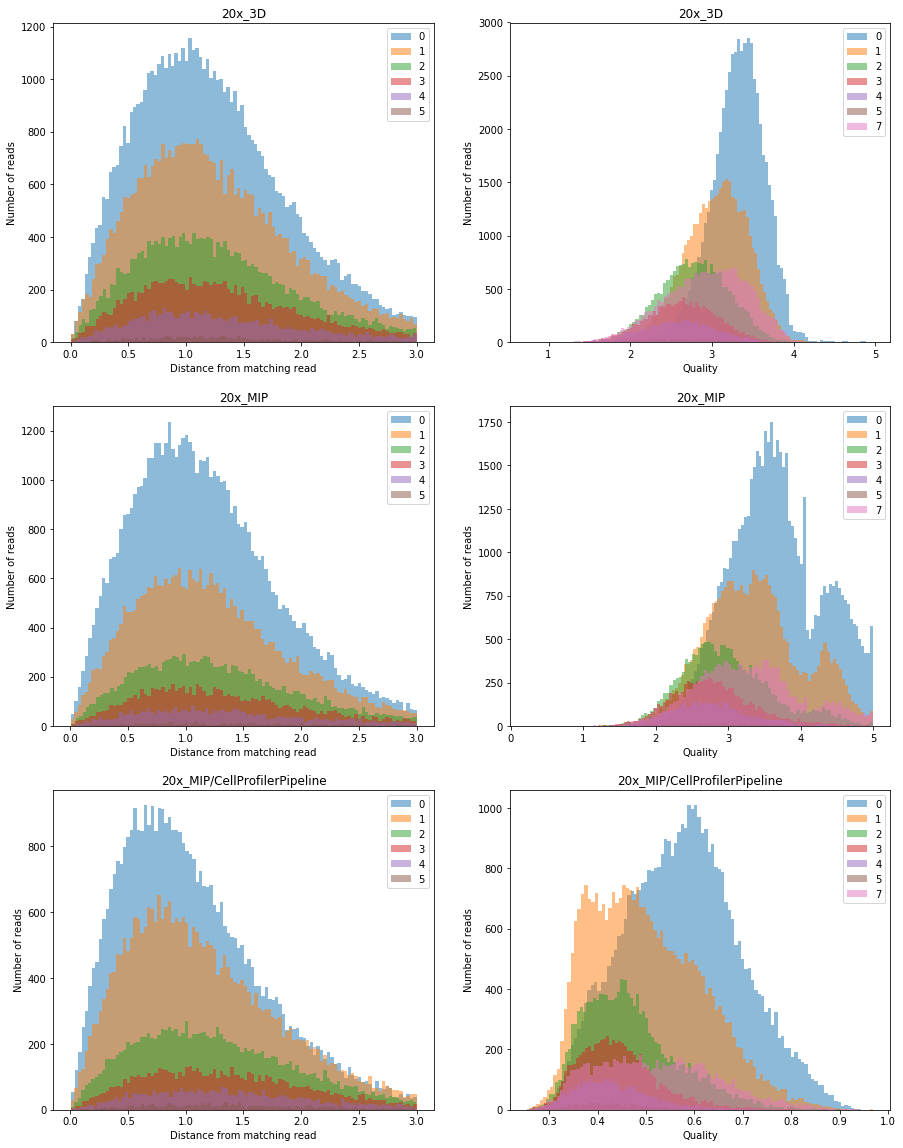

In [8]:
plt.figure(figsize=(15,20))
for p,df in enumerate(dataset_list):
    barcodes_df = pd.read_pickle("../data/results/170315_161220_4_1/"+df+"/barcodes_df.hdf5")
    target_df = pd.read_pickle("../data/results/170315_161220_4_1/"+df+"/target_df.hdf5")

    plt.subplot(len(dataset_list),2,2*p+1)
    plt.rcParams["figure.dpi"] = 150
    for i in range(len(barcodes_df.letters[0])+1):
        plt.hist(np.array(target_df[(target_df.levenshtein_d==i) & (target_df.d.notnull())].d),bins=100,alpha=0.5,label=str(i))
    plt.legend()
    plt.title(df)
    plt.xlabel("Distance from matching read")
    plt.ylabel("Number of reads")

    plt.subplot(len(dataset_list),2,2*p+2)
    plt.rcParams["figure.dpi"] = 150
    for i in range(len(barcodes_df.letters[0])+1):
        plt.hist(np.array(barcodes_df.loc[target_df[target_df.levenshtein_d==i].idx].seq_quality_min),bins=100,alpha=0.5,label=str(i))
    # Plot False Negative
    plt.hist(np.array(barcodes_df[barcodes_df.levenshtein_d==7].seq_quality_min),bins=100,alpha=0.5,label=7)
    plt.legend()
    plt.title(df)
    plt.xlabel("Quality")
    plt.ylabel("Number of reads")

### Plot Precision VS Recall
For each analysis result plot Precision vs Recal. For a given quality threshold, True Positive (TP), False Positive (FP), True Negative (TN), False negative (FN), are computed as follow:
- TP: reads that have a matching ground truth read (i.e. if a read is decoded in the ground truth within an euclidean distance equal to 3. If multiple reads are present, the closest read is considered as matching read) with 0 mismatches, and that pass quality threshold. Also, reads that have a matching ground truth read with 1 base mismatch and that are expected sequences of the taglist are considered as 0 mismatch reads,
- FP: reads that have a matching ground truth read with >0 mismatches and reads that do not have a matching read, and that pass quality threashold,
- TN: reads that have a matching ground truth read with >0 mismatches, and that do not pass quality threshold,
- FN: reads that have a matching ground truth read with 0 mismatches that do not pass quality threshold, and ground truth reads that are expected sequences of the taglist that do not have a matching read.

Precision and Recall are evalueted on a cut-out of the sample common to 40x and 20x data. The image cut-out is then partitioned in 4 different quadrants in order to get precision confidence intervals for given values of recall.

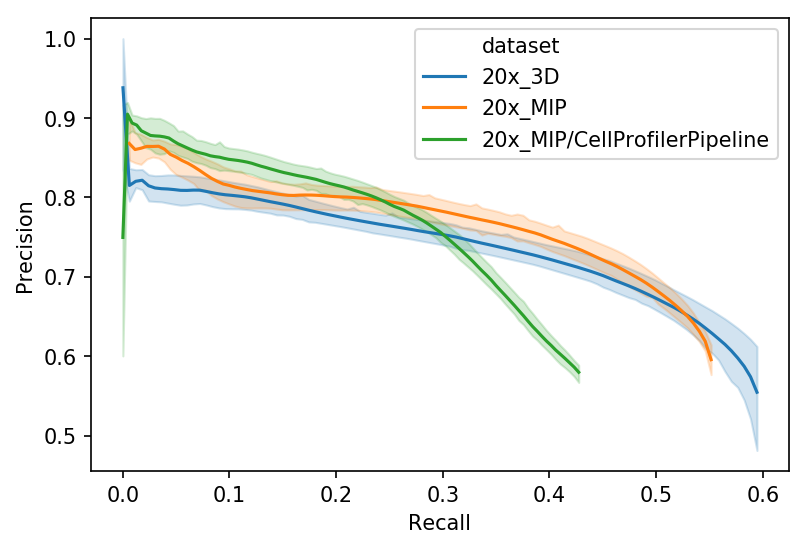

In [9]:
from scipy.interpolate import interp1d

# image cut-out coordinates
coord_max =np.array([12008,9960,1])
coord_min =np.array([1000,1000,1])

l_th=0
def PrecRecall(barcodes_df,target_df,l_th):
    exp_df = barcodes_df[barcodes_df.levenshtein_d<=l_th]
    unexp_df = barcodes_df[(barcodes_df.levenshtein_d>l_th)]

    p=[]
    r=[]
    q_th=[]
    n_bins = 100
    fp_minQ = unexp_df.seq_quality_min.min()
    fp_maxQ = unexp_df.seq_quality_min.max()
    tp_minQ = exp_df.seq_quality_min.min()
    tp_maxQ = exp_df.seq_quality_min.max()
    Q_min = np.amin([fp_minQ,tp_minQ])
    Q_max = np.amax([fp_maxQ,tp_maxQ])
    step = (Q_max-Q_min)/n_bins
    Q=Q_min
    for n in range(n_bins):
        tp = len(exp_df[(exp_df.seq_quality_min>=Q)])
        fp = len(unexp_df[unexp_df.seq_quality_min>=Q])
        tn = len(unexp_df[unexp_df.seq_quality_min<Q])
        fn = len(exp_df[exp_df.seq_quality_min<Q]) + len(target_df[(target_df.levenshtein_d==6) & (target_df.letters.isin(tagList_df.Seq))])
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        p.append(precision)
        r.append(recall)
        q_th.append(Q)
        Q = Q + step
    return p,r,q_th

# Plot Precision-Recall curve
n=3
res_df = []
for df in dataset_list:
    bdf = pd.read_pickle("../data/results/170315_161220_4_1/"+df+"/barcodes_df.hdf5")
    tdf = pd.read_pickle("../data/results/170315_161220_4_1/"+df+"/target_df.hdf5")
    range_x = np.linspace(coord_min[0],coord_max[0],n).astype(np.uint)
    range_y = np.linspace(coord_min[1],coord_max[1],n).astype(np.uint)
    k=1
    res = []
    for i, c_i in enumerate(range_x[:-1]):
        for j,c_j in enumerate(range_y[:-1]):
            bdf_tmp = bdf[(bdf.tX2>=range_x[i]) & (bdf.tX2<=range_x[i+1]) & (bdf.tY2>=range_y[j]) & (bdf.tY2<=range_y[j+1])]
            tdf_tmp = tdf[(tdf.global_X_pos>=range_x[i]) & (tdf.global_X_pos<=range_x[i+1]) & (tdf.global_Y_pos>=range_y[j]) & (tdf.global_Y_pos<=range_y[j+1])]
            p,r,q_th = PrecRecall(bdf_tmp,tdf_tmp,0)
             
            res.append(pd.DataFrame({'Precision':p, 'Recall':r, 'Q_th': q_th,'dataset':df, 'patch':k}))
            k = k+1
    res = pd.concat(res)
    r = np.linspace(max([res[res.patch==x+1].Recall.min() for x in range(k-1)]),min([res[res.patch==x+1].Recall.max() for x in range(k-1)]),100, endpoint=True)
    
    for i in range(k-1):
        # resample from precision vs recall distribution at regular interval of recall
        f = interp1d(res[res.patch==i+1].Recall, res[res.patch==i+1].Precision, kind='linear')
        res_df.append(pd.DataFrame({'Precision':f(r), 'Recall':r, 'dataset':df, 'patch':i+1}))
res_df = pd.concat(res_df)
    
sns.lineplot(x="Recall", y="Precision",
             hue="dataset",
             data=res_df)